Fully Bayesian inference for generalized GP models with HMC
--

*James Hensman, 2015-16*

It's possible to construct a very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the GLM literature). This makes inference of the GP intractable since the likelihoods is not generally conjugate to the Gaussian process. The general form of the model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta))\\y_i \sim p(y | g(f(x_i))\,.$$


To perform inference in this model, we'll run MCMC using Hamiltonian Monte Carlo (HMC) over the function-values and the parameters $\theta$ jointly. Key to an effective scheme is rotation of the field using the Cholesky decomposition. We write

$$\theta \sim p(\theta)\\v \sim \mathcal {N}(0,\, I)\\LL^\top = K\\f = m + Lv\\y_i \sim p(y | g(f(x_i))\,.$$

Joint HMC over v and the function values is not widely adopted in the literature becate of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in tensorflow, and so application of HMC is relatively straightforward. 

### Exponential Regression example
The first illustration in this notebook is 'Exponential Regression'. The model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(0, k(x, x'; \theta))\\f_i = f(x_i)\\y_i \sim \mathcal {Exp} (e^{f_i})$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. first, generate a data set.

In [5]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

X = np.linspace(-3,3,20)
Y = np.random.exponential(np.sin(X)**2)

GPflow's model for fully-Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function. 

In [6]:
#build the model
k = GPflow.kernels.Matern32(1,ARD=False) + GPflow.kernels.Constant(1)
l = GPflow.likelihoods.Exponential()
m = GPflow.gpmc.GPMC(X[:,None], Y[:,None], k, l)
m

Name,values,prior,constraint
model.kern.matern32.lengthscales,[ 1.],None,+ve
model.kern.matern32.variance,[ 1.],None,+ve
model.kern.bias.variance,[ 1.],None,+ve
model.V,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)


The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are rather arbitrary, for illustration). 

In [16]:
m.kern.matern32.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.matern32.variance.prior = GPflow.priors.Gamma(1.,1.)
m.kern.bias.variance.prior = GPflow.priors.Gamma(1.,1.)

Running HMC is as easy as hitting m.sample(). GPflow only has HMC sampling for the moment, and it's a relatively vanilla implementation (no NUTS, for example). There are two setting to tune, the step size (epsilon) and the maximum noumber of steps Lmax. Each proposal will take a random number of steps between 1 and Lmax, each of length epsilon. 

We'll use the `verbose` setting so that we can see the acceptance rate.

In [38]:
m.optimize(max_iters=15) # start near MAP
samples = m.sample(500, verbose=True, epsilon=0.12, Lmax=15)

optimization terminated, setting model state
Iteration:  100 	 Acc Rate:  88.0 %
Iteration:  200 	 Acc Rate:  93.0 %
Iteration:  300 	 Acc Rate:  95.0 %
Iteration:  400 	 Acc Rate:  98.0 %
Iteration:  500 	 Acc Rate:  98.0 %


In [39]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []
for s in samples:
    m.set_state(s)
    f_samples.append(m.predict_f_samples(xtest, 5))
f_samples = np.vstack(f_samples)

    
    

(0, 5)

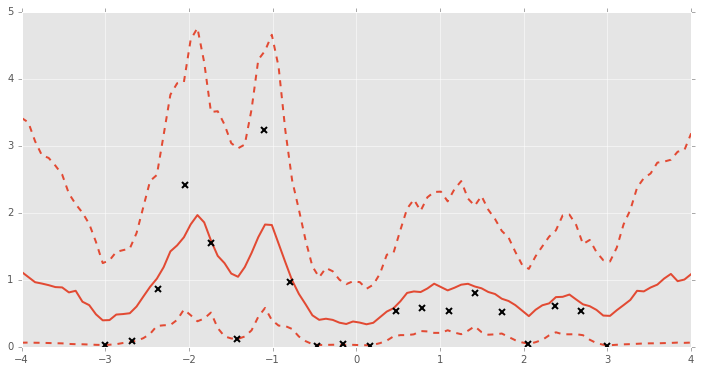

In [40]:


rate_samples = np.exp(f_samples[:,:,0])
plt.figure(figsize=(12, 6))
line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.plot(xtest, np.percentile(rate_samples, 5, axis=0), '--', color=line.get_color(), lw=2)
plt.plot(xtest, np.percentile(rate_samples, 95, axis=0), '--', color=line.get_color(), lw=2)
plt.plot(X, Y, 'kx', mew=2)
plt.ylim(0, 5)


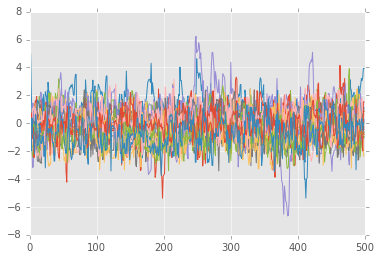

In [56]:
_ = plt.plot(samples)

In [42]:
kernel_samples = m.kern.get_samples_df(samples)

In [43]:
kernel_samples.head()

,model.kern.matern32.lengthscales,model.kern.matern32.variance,model.kern.bias.variance
0,[0.193534109912],[4.89197106348],[1.10492033877]
1,[0.187064515563],[4.98946002271],[0.988277453571]
2,[0.159016026668],[2.30869164377],[1.13099322098]
3,[0.222648091497],[1.04446351308],[0.166977652303]
4,[0.400906619739],[1.22793479968],[0.0408960241423]


In [54]:
kernel_samples.mean()

model.kern.matern32.lengthscales    0.581516
model.kern.matern32.variance        1.275505
model.kern.bias.variance            1.136915
dtype: float64

In [55]:
kernel_samples.std()

model.kern.matern32.lengthscales    0.578718
model.kern.matern32.variance        0.954359
model.kern.bias.variance            1.144346
dtype: float64